# Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


# План работы

1.Изучение данных.Заполнение и удаление пропусков.  
2.Подготовка данных.Объединение данных по ключу. Разделение данных на обучающую и тестовую выборку,выделение целевого признака.  
3.Обучение регрессионных моделей RandomForestRegressor,CatBoost.  
4.Оценка эффективности лучшей модели на тестовой выборке,сравнение с константной моделью.  
5.Отчет.

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor as cat

In [2]:
random_state = 120922

### Изучение данных об электродах

In [3]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [6]:
data_arc = data_arc[data_arc['Реактивная мощность']> 0] #уберем отрицательную мощность


In [7]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


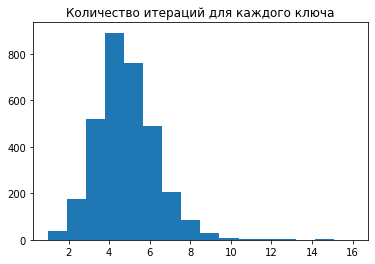

In [8]:
plt.hist(data_arc['key'].value_counts(),bins=16)
plt.title('Количество итераций для каждого ключа')
plt.show()


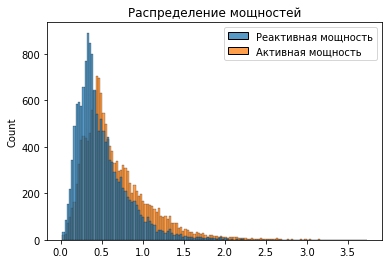

In [9]:
sns.histplot(data_arc[['Реактивная мощность','Активная мощность']])
plt.title('Распределение мощностей')
plt.show()

В таблице data_arc удален выброс по мощности,отсутствуют пропуски в данных. На каждый ключ,в основном,приходится несколько итераций.Чаще всего количество итераций = 4 ,максимальное количество итераций 14.Медианная активная мощность 0,56.Медианная реактивная мощность 0,41.

### Изучение данных о подаче сыпучих материалов

In [10]:
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [11]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


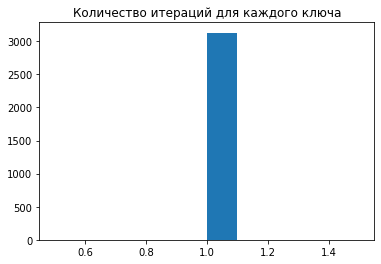

In [12]:
plt.hist(data_bulk['key'].value_counts())
plt.title('Количество итераций для каждого ключа')
plt.show()

In [13]:
data_bulk = data_bulk.set_index('key')
data_bulk.head()

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


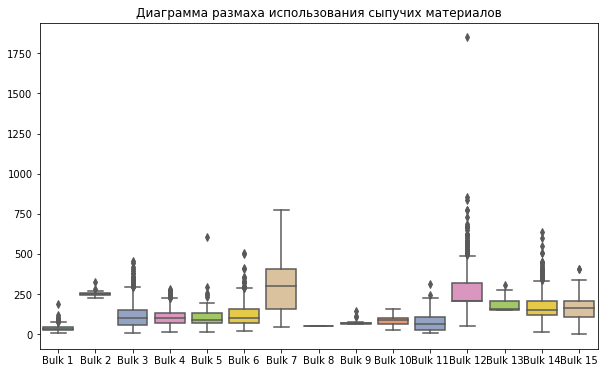

In [14]:
plt.figure(figsize=(10,6))
sns.boxplot(data = data_bulk,palette='Set2')
plt.title('Диаграмма размаха использования сыпучих материалов')
plt.show()

In [15]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   3129 non-null   float64
 1   Bulk 2   3129 non-null   float64
 2   Bulk 3   3129 non-null   float64
 3   Bulk 4   3129 non-null   float64
 4   Bulk 5   3129 non-null   float64
 5   Bulk 6   3129 non-null   float64
 6   Bulk 7   3129 non-null   float64
 7   Bulk 8   3129 non-null   float64
 8   Bulk 9   3129 non-null   float64
 9   Bulk 10  3129 non-null   float64
 10  Bulk 11  3129 non-null   float64
 11  Bulk 12  3129 non-null   float64
 12  Bulk 13  3129 non-null   float64
 13  Bulk 14  3129 non-null   float64
 14  Bulk 15  3129 non-null   float64
dtypes: float64(15)
memory usage: 391.1 KB


В таблице data_bulk на каждый ключ приходится одна запись/итерация.  Исходя из количества пропусков  в столбцах и диаграммы boxplot,некоторые материалы редко участвуют в производственном процессе. Пропуски заполнены 0.

### Изучение данных о продувке сплава газом

In [16]:
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [17]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


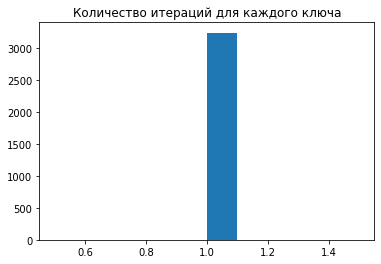

In [18]:
plt.hist(data_gas['key'].value_counts())
plt.title('Количество итераций для каждого ключа')
plt.show()

In [19]:
data_gas = data_gas.set_index('key')
data_gas.head()

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


In [20]:
data_gas.describe()

,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


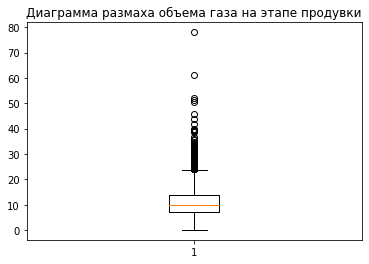

In [21]:
plt.boxplot(data_gas['Газ 1'].values)
plt.title('Диаграмма размаха объема газа на этапе продувки')
plt.show()


В таблице data_gas на каждый ключ приходится одна запись/итерация. Пропусков нет.

### Изучение результатов измерения температуры;

In [22]:
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [23]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [24]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


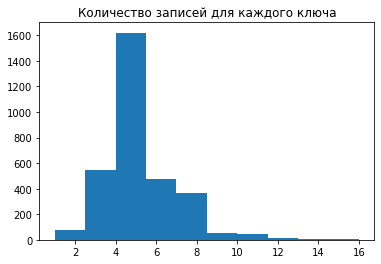

In [25]:
plt.hist(data_temp['key'].value_counts())
plt.title('Количество записей для каждого ключа')
plt.show()

In [26]:
data_temp[data_temp['Температура'] < 1500]

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


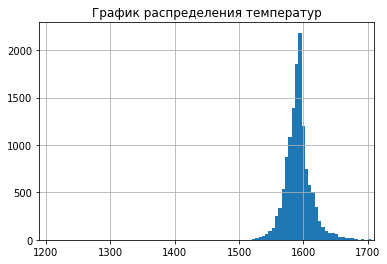

In [27]:
data_temp['Температура'].hist(bins=100)
plt.xlim([1190,1710])
plt.title('График распределения температур')
plt.show()

In [28]:
data_temp = data_temp[data_temp['Температура'] >1499]

Температура на графике имеет нормальное распределение.Температура ниже 1500 встречается редко,на графике ее не видно.Выброс температуры 1191 градус - удален. 

### Изучение данных о подаче проволочных материалов

In [29]:
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


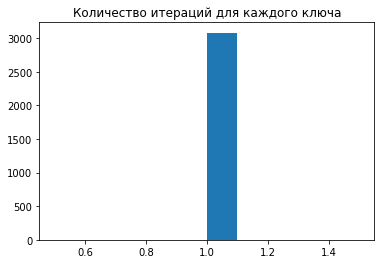

In [30]:
plt.hist(data_wire['key'].value_counts())
plt.title('Количество итераций для каждого ключа')
plt.show()

In [31]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
data_wire = data_wire.set_index('key')
data_wire 

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


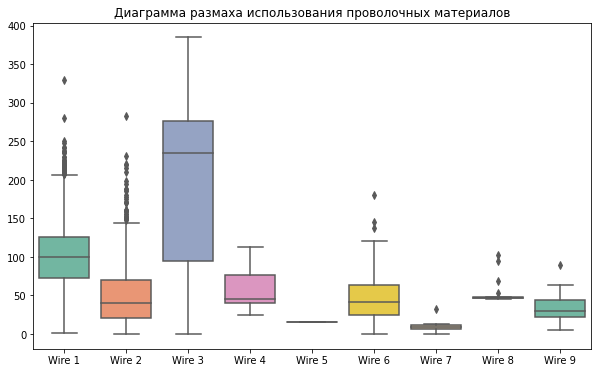

In [33]:
plt.figure(figsize=(10,6))
sns.boxplot(data = data_wire,palette='Set2')
plt.title('Диаграмма размаха использования проволочных материалов')
plt.show()

In [34]:
data_wire = data_wire.fillna(0)
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3081 non-null   float64
 1   Wire 2  3081 non-null   float64
 2   Wire 3  3081 non-null   float64
 3   Wire 4  3081 non-null   float64
 4   Wire 5  3081 non-null   float64
 5   Wire 6  3081 non-null   float64
 6   Wire 7  3081 non-null   float64
 7   Wire 8  3081 non-null   float64
 8   Wire 9  3081 non-null   float64
dtypes: float64(9)
memory usage: 240.7 KB


В таблице data_wire на каждый ключ приходится одна запись/итерация. Исходя из количества пропусков  в столбцах и диаграммы boxplot,некоторые материалы редко участвуют в производственном процессе. Пропуски заполнены 0.

### Вывод
Датасеты data_bulk и data_wire имеют большое количество пропусков,это связано с особенностями производственного процесса.Некоторые материалы редко используют в процессе производства.Пропуски заполнены 0.  
Датасет data_temp,пропуски и партии, в которых указана только одна температура, необходимо удалить.Последняя измеряемая температура для каждого ключа является целевым признаком.  
Датасет data_arc каждый ключ имеет несколько итераций,необходимо сформировать один признак для каждого ключа.
Все датасеты необходимо объединить по ключу,для этого ключ сделать индексом.

## Подготовка данных

In [35]:
new_arc = pd.pivot_table(data_arc,index='key',values =['Активная мощность','Реактивная мощность'],aggfunc = 'mean')
new_arc

,Активная мощность,Реактивная мощность
key,,
1,0.975629,0.636648
2,0.763150,0.499528
3,0.505176,0.319815
4,0.802313,0.515074
5,0.836793,0.563161
...,...,...
3237,0.786493,0.565692
3238,0.702176,0.560394
3239,0.583344,0.388952


In [36]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           12999 non-null  int64  
 1   Время замера  12999 non-null  object 
 2   Температура   12999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB


In [37]:
new_key = pd.DataFrame(data_temp['key'].value_counts().reset_index())
new_key  = new_key[new_key['key'] > 1]
n = list(new_key['index'])

In [38]:
new_temp = data_temp.query('key in @n')
new_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12262,2498,2019-08-06 02:19:26,1593.0
12263,2498,2019-08-06 02:25:31,1594.0
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0


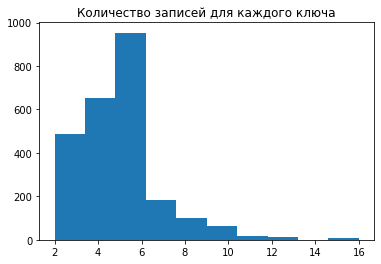

In [39]:
plt.hist(new_temp['key'].value_counts())
plt.title('Количество записей для каждого ключа')
plt.show()

In [40]:
first_temp = new_temp.groupby('key').first()
first_temp = first_temp.drop('Время замера',axis=1)
first_temp.rename(columns={'Температура':'Начальная температура'},inplace=True)


In [41]:
last_temp = new_temp.groupby('key').last()
last_temp = last_temp.drop('Время замера',axis=1)
last_temp.rename(columns={'Температура':'Последняя температура'},inplace=True)

In [42]:
df = pd.merge(last_temp,first_temp,left_index=True, right_index=True, how='inner')
df

,Последняя температура,Начальная температура
key,,
1,1613.0,1571.0
2,1602.0,1581.0
3,1599.0,1596.0
4,1625.0,1601.0
5,1602.0,1576.0
...,...,...
2495,1591.0,1570.0
2496,1591.0,1554.0
2497,1589.0,1571.0


In [43]:
df = pd.merge(df,new_arc,left_index=True, right_index=True, how='inner')
df

,Последняя температура,Начальная температура,Активная мощность,Реактивная мощность
key,,,,
1,1613.0,1571.0,0.975629,0.636648
2,1602.0,1581.0,0.763150,0.499528
3,1599.0,1596.0,0.505176,0.319815
4,1625.0,1601.0,0.802313,0.515074
5,1602.0,1576.0,0.836793,0.563161
...,...,...,...,...
2495,1591.0,1570.0,0.802673,0.590194
2496,1591.0,1554.0,0.700511,0.468364
2497,1589.0,1571.0,0.737460,0.617090


In [44]:
df = pd.merge(df,data_wire,left_index=True, right_index=True, how='inner')
df

,Последняя температура,Начальная температура,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,
1,1613.0,1571.0,0.975629,0.636648,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1602.0,1581.0,0.763150,0.499528,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1599.0,1596.0,0.505176,0.319815,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1625.0,1601.0,0.802313,0.515074,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1602.0,1576.0,0.836793,0.563161,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,1570.0,0.802673,0.590194,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,1591.0,1554.0,0.700511,0.468364,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,1589.0,1571.0,0.737460,0.617090,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df = pd.merge(df,data_gas,left_index=True, right_index=True, how='inner')
df

,Последняя температура,Начальная температура,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
key,,,,,,,,,,,,,,
1,1613.0,1571.0,0.975629,0.636648,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,1602.0,1581.0,0.763150,0.499528,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,1599.0,1596.0,0.505176,0.319815,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793
4,1625.0,1601.0,0.802313,0.515074,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219
5,1602.0,1576.0,0.836793,0.563161,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,1570.0,0.802673,0.590194,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.125735
2496,1591.0,1554.0,0.700511,0.468364,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.412616
2497,1589.0,1571.0,0.737460,0.617090,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.271699


In [46]:
df = pd.merge(df,data_bulk,left_index=True, right_index=True, how='inner')
df

,Последняя температура,Начальная температура,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,,,,,,,
1,1613.0,1571.0,0.975629,0.636648,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,1602.0,1581.0,0.763150,0.499528,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,1599.0,1596.0,0.505176,0.319815,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,1625.0,1601.0,0.802313,0.515074,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,1602.0,1576.0,0.836793,0.563161,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1591.0,1570.0,0.802673,0.590194,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2496,1591.0,1554.0,0.700511,0.468364,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2497,1589.0,1571.0,0.737460,0.617090,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0


In [47]:
df.describe()

,Последняя температура,Начальная температура,Активная мощность,Реактивная мощность,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,...,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,1593.365393,1587.386003,0.669044,0.499276,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,...,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769
std,11.200915,23.619841,0.196943,0.147383,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,...,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443
min,1541.000000,1519.000000,0.186226,0.130062,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1587.000000,1571.000000,0.526430,0.392506,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000
50%,1593.000000,1587.000000,0.644404,0.487685,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000
75%,1598.000000,1603.000000,0.792065,0.592351,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000
max,1653.000000,1660.000000,1.421416,1.134983,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,...,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [48]:
features = df.drop('Последняя температура',axis=1)
target = df['Последняя температура']

In [49]:
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size = 0.25,random_state = random_state)

In [50]:
features_train.shape

(1746, 28)

In [51]:
features_test.shape

(583, 28)

## Обучение регрессионых моделей

In [53]:
model = cat(random_state=random_state,verbose=10)
params = {'learning_rate': [0.01,0.02, 0.03,0.05,0.1,0.3],
        'depth': range(1, 16),
        'l2_leaf_reg': range(1,15),
        'n_estimators' : range(1, 1000),
         'min_child_samples':range(1,50)}

r_cv = RandomizedSearchCV(estimator=model, param_distributions=params, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
r_cv.fit(features,target)
print('Best hyperparams: ', r_cv.best_params_)
print('Best score:',r_cv.best_score_)
params_best =  r_cv.best_params_

0:	learn: 11.1449314	total: 375ms	remaining: 5m 22s
10:	learn: 10.3437055	total: 3.33s	remaining: 4m 17s
20:	learn: 9.6955844	total: 6.5s	remaining: 4m 19s
30:	learn: 9.1661044	total: 9.64s	remaining: 4m 18s
40:	learn: 8.7038031	total: 12.9s	remaining: 4m 18s
50:	learn: 8.2973697	total: 16.1s	remaining: 4m 15s
60:	learn: 7.9568220	total: 19.3s	remaining: 4m 12s
70:	learn: 7.6642196	total: 22.5s	remaining: 4m 10s
80:	learn: 7.4080220	total: 25.2s	remaining: 4m 2s
90:	learn: 7.1868713	total: 28.2s	remaining: 3m 58s
100:	learn: 6.9891378	total: 31.4s	remaining: 3m 56s
110:	learn: 6.7980748	total: 34.6s	remaining: 3m 53s
120:	learn: 6.6453189	total: 37.8s	remaining: 3m 50s
130:	learn: 6.5386030	total: 40.7s	remaining: 3m 46s
140:	learn: 6.4357956	total: 44.1s	remaining: 3m 45s
150:	learn: 6.3335423	total: 47.2s	remaining: 3m 41s
160:	learn: 6.2509824	total: 50.2s	remaining: 3m 38s
170:	learn: 6.1528988	total: 53s	remaining: 3m 33s
180:	learn: 6.0645354	total: 56s	remaining: 3m 30s
190:	lea

In [54]:
model = RandomForestRegressor(random_state=random_state)
param_dist = {'n_estimators': range(1,1000),
               'max_features': ['auto', 'sqrt', 'log2', None],
               'max_depth': range(1,150),
               'min_samples_split': range(1,30),
               'min_samples_leaf': range(1,30)}
rs =  RandomizedSearchCV(model,param_distributions = param_dist, cv=5,scoring='neg_mean_absolute_error', verbose=10)
rs.fit(features_train, target_train)
best_params = rs.best_params_
print('Best hyperparams RandomForestRegressor: ', rs.best_params_)
print('Best score RandomForestRegressor:',rs.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968
[CV 1/5; 1/10] END max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968; total time=   4.0s
[CV 2/5; 1/10] START max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968
[CV 2/5; 1/10] END max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968; total time=   3.9s
[CV 3/5; 1/10] START max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968
[CV 3/5; 1/10] END max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968; total time=   4.0s
[CV 4/5; 1/10] START max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_split=13, n_estimators=968
[CV 4/5; 1/10] END max_depth=54, max_features=auto, min_samples_leaf=27, min_samples_sp

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV 1/5; 9/10] END max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954; total time=   0.3s
[CV 2/5; 9/10] START max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV 2/5; 9/10] END max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954; total time=   0.3s
[CV 3/5; 9/10] START max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV 3/5; 9/10] END max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954; total time=   0.3s
[CV 4/5; 9/10] START max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV 4/5; 9/10] END max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954; total time=   0.3s
[CV 5/5; 9/10] START max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 387, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/

[CV 5/5; 9/10] END max_depth=102, max_features=sqrt, min_samples_leaf=24, min_samples_split=1, n_estimators=954; total time=   0.3s
[CV 1/5; 10/10] START max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198
[CV 1/5; 10/10] END max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198; total time=   0.4s
[CV 2/5; 10/10] START max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198
[CV 2/5; 10/10] END max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198; total time=   0.4s
[CV 3/5; 10/10] START max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198
[CV 3/5; 10/10] END max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198; total time=   0.4s
[CV 4/5; 10/10] START max_depth=66, max_features=log2, min_samples_leaf=4, min_samples_split=12, n_estimators=198
[CV 4/5; 10/10] 

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [-6.7917433  -6.67347131 -6.73404302 -6.67011581 -7.14969289 -6.7013485
 -7.11965221 -6.67027505         nan -6.84368738]
  warnings.warn(


Best hyperparams RandomForestRegressor:  {'n_estimators': 489, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': None, 'max_depth': 8}
Best score RandomForestRegressor: -6.6701158079650185


## Оценка эффективности модели

In [55]:
strategy = ['mean', 'median']
for s in strategy:
    model_dummy = DummyRegressor(strategy = s)
    model_dummy.fit(features_train,target_train)
    predict = model_dummy.predict(features_test)
    mae = mean_absolute_error(target_test,predict)
    print('MAE на тесте',mae)

MAE на тесте 8.110664120292613
MAE на тесте 8.04459691252144


In [56]:
model_cat = cat(**params_best)
model_cat.fit(features_train,target_train)

0:	learn: 10.6908465	total: 1.19ms	remaining: 111ms
1:	learn: 10.4201653	total: 2.44ms	remaining: 112ms
2:	learn: 10.0506478	total: 3.6ms	remaining: 109ms
3:	learn: 9.9644544	total: 4.73ms	remaining: 106ms
4:	learn: 9.7053472	total: 5.72ms	remaining: 102ms
5:	learn: 9.5118721	total: 6.75ms	remaining: 99ms
6:	learn: 9.3907515	total: 7.77ms	remaining: 96.5ms
7:	learn: 9.2683804	total: 8.72ms	remaining: 93.7ms
8:	learn: 9.2356839	total: 9.77ms	remaining: 92.2ms
9:	learn: 9.1681340	total: 10.8ms	remaining: 90.7ms
10:	learn: 9.0386549	total: 11.8ms	remaining: 89.4ms
11:	learn: 8.9980179	total: 12.9ms	remaining: 88.3ms
12:	learn: 8.9165355	total: 14ms	remaining: 87.1ms
13:	learn: 8.8171426	total: 15.1ms	remaining: 86.1ms
14:	learn: 8.7346758	total: 16ms	remaining: 84.4ms
15:	learn: 8.6984682	total: 17.2ms	remaining: 84.1ms
16:	learn: 8.6178267	total: 18.3ms	remaining: 83.1ms
17:	learn: 8.6002532	total: 19.4ms	remaining: 81.9ms
18:	learn: 8.5427260	total: 20.5ms	remaining: 81ms
19:	learn: 8.5

In [57]:
pred = model_cat.predict(features_test)
mae = mean_absolute_error(target_test,pred)
print('MAE на тестовой выборке',mae )

MAE на тестовой выборке 6.663233054539539


In [58]:
feature_importance = pd.Series(model_cat.feature_importances_,index=features_train.columns).sort_values(ascending=False).to_frame()
feature_importance

,0
Начальная температура,27.498354
Активная мощность,19.896717
Wire 1,10.159056
Bulk 12,8.460055
Bulk 15,6.308040
Bulk 6,5.364061
Bulk 1,4.040463
Газ 1,3.680342
Wire 2,3.280679
Bulk 14,2.715660


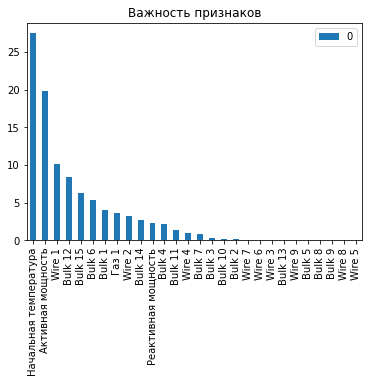

In [60]:
feature_importance.plot(title ='Важность признаков',kind='bar');

# Вывод

Лучшая модель CatBoostRegressor с гиперпараметрами:
    n_estimators = 94, min_child_samples = 1,  
    learning_rate = 0.3, l2_leaf_reg = 7, depth = 3  
    MAE на тестовой выборке 6.663233054539539  
    Анализ важности признаков показал,что самыми важными признаками являются:  
    Начальная температура  
    Активная мощность  
    Wire 1
    

## Отчет

В этом проекте нам необходимо предсказать температуру стали,для оптимизации производственных расходов.Данные состоят из 7 файлов.  
data_arc — данные об электродах(содержит активную и реактивную мощность, время начала и конец нагрева)  
data_bulk — данные о подаче сыпучих материалов (объём);  
data_bulk_time — данные о подаче сыпучих материалов (время);  
data_gas — данные о продувке сплава газом;  
data_temp — результаты измерения температуры(время и температура на каждом этапе);  
data_wire — данные о проволочных материалах (объём);  
data_wire_time — данные о проволочных материалах (время).

# Какие пункты плана были выполнены, а какие — нет (поясните почему)?
В данном проекте выполнены были все пункты плана.План состоял из основных пунктов по предобработке и изучению моделей.

# Какие трудности возникли и как вы их преодолели?
Трудности возникли в понимании производственного процесса,о том как соотносить между собой разные этапы для партий.Получив более подробную информацию,трудности были преодалены.

# Какие ключевые шаги в решении задачи выделили?
На этапе изучения данных ,выявлено несколько выбросов ,которые являются аномальными для данного производственного процесса,температура меньше 1500 градусов,большая отрицательная активная мощность.Данные были почищены.
Датасеты data_bulk и data_wire содержат информацию о материалах,которые добавляют в сплав. Материалы используют в разных количествах,из-за особенностей производственного процесса,некоторые материалы практически не используют.

На этапе подготовки данных для модели,данные из таблиц об электродах(data_arc.),о объемах сыпучих материалов (data_bulk),о объеме проволочных материалах(data_wire),данные о продувке сплава газом(data_gas), и результатов измерения температуры на разных этапах (data_temp),были соеденены в одну таблицу по номеру партии. При этом,для каждой партии,из всех этапов найдена средняя активная и реактивная мощность ,из таблицы об электродах. Первая измеряемая температура ,стала признаком для модели.Последняя измеряемая температура стала целевым признаком.Данные поделены на обучающую и тренировочную выборку в соотношении 75/25.

На этапе обучения моделей,было выбрано 2 модели,CatBoostRegressor и RandomForestRegressor.
Для выбора лучшей модели,ориентир на метрику на кросс-валидации.
CatBoostRegressor -6.616273178356025
RandomForestRegressor -6.6701158079650185


# Какая ваша итоговая модель и какое у неё качество? 
Лучшая модель CatBoostRegressor с гиперпараметрами: n_estimators = 94, min_child_samples = 1, learning_rate = 0.3, l2_leaf_reg = 7, depth = 3 MAE на тестовой выборке 6.663233054539539 Анализ важности признаков показал,что самыми важными признаками являются: Начальная температура Активная мощность Wire 1 При этом констатные модели выдавали 8.04459691252144 на медиане, 8.110664120292613 на среднем Лучшая модель примерно на 17% лучше константной